# Chapter 2 - Financial Data Structures

### Exercise 2.1
**Note:** Adapted for BTCUSDT for a year long dataset from Binance 
(Concretely the spans approximately 13 months: October 16, 2024 to October 17, 2025)

In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import time

# for the classes to handle dynamic thresholds
import json
from dataclasses import dataclass

In [2]:
@dataclass
class BarThresholds:
    """Store and manage bar formation thresholds"""
    tick_threshold: int
    volume_threshold: float
    dollar_threshold: float
    target_bars: int
    data_span_days: int
    
    def to_dict(self):
        return {
            'tick_threshold': self.tick_threshold,
            'volume_threshold': float(self.volume_threshold),
            'dollar_threshold': float(self.dollar_threshold),
            'target_bars': self.target_bars,
            'data_span_days': self.data_span_days
        }
    
    def save(self, filepath):
        Path(filepath).parent.mkdir(parents=True, exist_ok=True)
        with open(filepath, 'w') as f:
            json.dump(self.to_dict(), f, indent=2)
        print(f"✓ Thresholds saved to {filepath}")
    
    @staticmethod
    def load(filepath):
        with open(filepath, 'r') as f:
            d = json.load(f)
        return BarThresholds(**d)

    def display(self):
        """Pretty print threshold information"""
        print(f"\n{'='*60}")
        print(f"BAR FORMATION THRESHOLDS")
        print(f"{'='*60}")
        print(f"Tick threshold:    {self.tick_threshold:,} ticks per bar")
        print(f"Volume threshold:  {self.volume_threshold:,.2f} BTC per bar")
        print(f"Dollar threshold:  ${self.dollar_threshold:,.0f} per bar")
        print(f"Target bars:       {self.target_bars:,}")
        print(f"Data span:         {self.data_span_days} days")
        print(f"{'='*60}\n")


In [3]:
# Load one file to inspect
data_dir = Path('../binance_raw_data/BTCUSDT')
sample_file = data_dir / '2025-07-09.parquet'

df = pd.read_parquet(sample_file)

# Basic inspection
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)

Shape: (626949, 6)

Columns: ['timestamp', 'symbol', 'price', 'quantity', 'dollar_volume', 'is_buyer_maker']

First few rows:
                timestamp   symbol      price  quantity  dollar_volume  \
0 2025-07-08 16:00:00.029  BTCUSDT  108268.35   0.00434     469.884639   
1 2025-07-08 16:00:00.187  BTCUSDT  108268.34   0.00058      62.795637   
2 2025-07-08 16:00:00.250  BTCUSDT  108268.35   0.00012      12.992202   
3 2025-07-08 16:00:00.402  BTCUSDT  108268.35   0.00021      22.736354   
4 2025-07-08 16:00:00.517  BTCUSDT  108268.34   0.00180     194.883012   

   is_buyer_maker  
0           False  
1            True  
2           False  
3           False  
4            True  

Data types:
timestamp         datetime64[ns]
symbol                    object
price                    float64
quantity                 float64
dollar_volume            float64
is_buyer_maker              bool
dtype: object


Let's start by importing a sample of the raw predownloaded BTC data into the notebook

lets discuss! so each row is a trade, where:
 - **price** (108268.35): This is the exchange rate at which the trade occurred—the value of one Bitcoin (BTC) expressed in the quote currency, Tether (USDT), which is pegged to the US Dollar.
 - **quantity** (0.00434): This is the amount of Bitcoin that was bought or sold in that single, specific transaction. It represents the trade size in terms of the base asset (BTC).
 - **dollar_volume** (469.884639): This is the total monetary value of the transaction in US Dollars, calculated by multiplying the $\text{price} \times \text{quantity}$. This figure represents the actual capital exchanged, making it the key metric for building Dollar Bars.

lets view a single day...

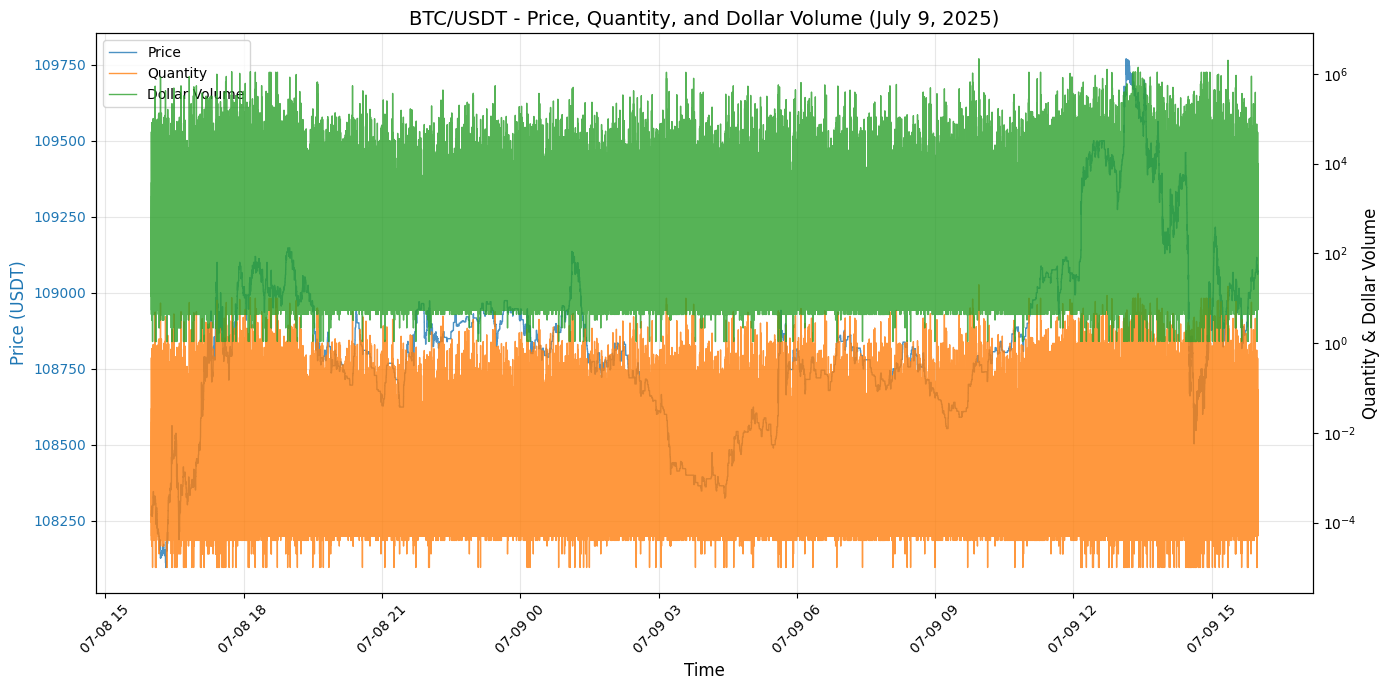

In [4]:
# Plot price, quantity, and dollar_volume with dual y-axes just to see it
import matplotlib.pyplot as plt

# Set timestamp as the index
df_sorted = df.sort_values('timestamp')
df_sorted.set_index('timestamp', inplace=True)

# Create figure with two y-axes (because scales are very different)
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot price on the left y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Price (USDT)', color=color1, fontsize=12)
line1 = ax1.plot(df_sorted.index, df_sorted['price'], color=color1, linewidth=1, label='Price', alpha=0.8)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Create a second y-axis on the right for quantity and dollar_volume
ax2 = ax1.twinx()
color2 = 'tab:orange'
color3 = 'tab:green'
ax2.set_ylabel('Quantity & Dollar Volume', fontsize=12)

# Plot quantity and dollar_volume on log scale (right y-axis)
line2 = ax2.plot(df_sorted.index, df_sorted['quantity'], color=color2, linewidth=1, label='Quantity', alpha=0.8)
line3 = ax2.plot(df_sorted.index, df_sorted['dollar_volume'], color=color3, linewidth=1, label='Dollar Volume', alpha=0.8)

# Use log scale on the right y-axis to handle the large range
ax2.set_yscale('log')

# Rotate x-axis labels
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Add title
ax1.set_title('BTC/USDT - Price, Quantity, and Dollar Volume (July 9, 2025)', fontsize=14)

# Combine legends from both axes
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

# Tight layout to prevent label cutoff
plt.tight_layout()

plt.show()

**Discussion:**
What we are seeing here is granular transaction-level noise. Each individual trade has a different quantity and value. Some trades are tiny (0.00001 BTC), others are larger (1 BTC+). The plot is showing every single fluctuation, which creates visual noise

Now lets import the entire series of data

In [5]:
# Load all parquet files
all_files = sorted(data_dir.glob('*.parquet'))
print(f"Found {len(all_files)} files")

# Concatenate all files
df_all = pd.concat([pd.read_parquet(f) for f in all_files], ignore_index=True)

print(f"\nTotal ticks: {len(df_all):,}")
print(f"Date range: {df_all['timestamp'].min()} to {df_all['timestamp'].max()}")
print(f"Memory usage: {df_all.memory_usage(deep=True).sum() / 1e6:.2f} MB")

Found 366 files

Total ticks: 511,953,309
Date range: 2024-10-16 16:00:00.030000 to 2025-10-17 15:59:59.747000
Memory usage: 45563.84 MB


### 2.1 On a series of BTCUSDT tick data...

#### (2.1a) Form tick, volume, and dollar bars.

In [6]:
# Optimised Tick Bars
def form_tick_bars_fast(df, tick_threshold):
    """
    Vectorised tick bar formation - slices instead of row-by-row
    """
    n_bars = len(df) // tick_threshold
    
    # Pre-allocate arrays for speed
    timestamps = np.empty(n_bars, dtype='datetime64[ns]')
    opens = np.empty(n_bars)
    highs = np.empty(n_bars)
    lows = np.empty(n_bars)
    closes = np.empty(n_bars)
    volumes = np.empty(n_bars)
    dollar_volumes = np.empty(n_bars)
    
    prices = df['price'].values
    quantities = df['quantity'].values
    dollars = df['dollar_volume'].values
    times = df['timestamp'].values
    
    for i in range(n_bars):
        start_idx = i * tick_threshold
        end_idx = start_idx + tick_threshold
        
        timestamps[i] = times[end_idx - 1]
        opens[i] = prices[start_idx]
        highs[i] = prices[start_idx:end_idx].max()
        lows[i] = prices[start_idx:end_idx].min()
        closes[i] = prices[end_idx - 1]
        volumes[i] = quantities[start_idx:end_idx].sum()
        dollar_volumes[i] = dollars[start_idx:end_idx].sum()
    
    return pd.DataFrame({
        'timestamp': timestamps,
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes,
        'dollar_volume': dollar_volumes,
        'num_ticks': tick_threshold
    })

# Tick Bar Function
def form_tick_bars(df, tick_threshold):
    """
    Form tick bars - sample every N ticks
    
    Parameters:
    -----------
    df : pd.DataFrame
        Tick data with columns: timestamp, price, quantity, dollar_volume
    tick_threshold : int
        Number of ticks per bar
    
    Returns:
    --------
    pd.DataFrame with OHLC bars
    """
    bars = []
    
    for i in range(0, len(df), tick_threshold):
        # Get chunk of ticks
        chunk = df.iloc[i:i+tick_threshold]
        
        if len(chunk) == 0:
            continue
            
        bar = {
            'timestamp': chunk['timestamp'].iloc[-1],  # Close time
            'open': chunk['price'].iloc[0],
            'high': chunk['price'].max(),
            'low': chunk['price'].min(),
            'close': chunk['price'].iloc[-1],
            'volume': chunk['quantity'].sum(),
            'dollar_volume': chunk['dollar_volume'].sum(),
            'num_ticks': len(chunk)
        }
        bars.append(bar)
    
    return pd.DataFrame(bars)

In [7]:
# Optimised Volume Bars
def form_volume_bars_fast(df, volume_threshold):
    """
    Vectorised volume bar formation using cumsum + searchsorted
    """
    # Cumulative volume
    cumsum_volume = df['quantity'].cumsum().values
    
    # Find bar boundaries efficiently
    thresholds = np.arange(volume_threshold, cumsum_volume[-1], volume_threshold)
    bar_indices = np.searchsorted(cumsum_volume, thresholds)
    bar_indices = np.insert(bar_indices, 0, 0)
    
    # Extract values as numpy arrays for speed
    prices = df['price'].values
    quantities = df['quantity'].values
    dollars = df['dollar_volume'].values
    times = df['timestamp'].values
    
    # Pre-allocate
    n_bars = len(bar_indices) - 1
    timestamps = np.empty(n_bars, dtype='datetime64[ns]')
    opens = np.empty(n_bars)
    highs = np.empty(n_bars)
    lows = np.empty(n_bars)
    closes = np.empty(n_bars)
    volumes = np.empty(n_bars)
    dollar_volumes = np.empty(n_bars)
    num_ticks = np.empty(n_bars, dtype=int)
    
    for i in range(n_bars):
        start = bar_indices[i]
        end = bar_indices[i + 1]
        
        timestamps[i] = times[end - 1]
        opens[i] = prices[start]
        highs[i] = prices[start:end].max()
        lows[i] = prices[start:end].min()
        closes[i] = prices[end - 1]
        volumes[i] = quantities[start:end].sum()
        dollar_volumes[i] = dollars[start:end].sum()
        num_ticks[i] = end - start
    
    return pd.DataFrame({
        'timestamp': timestamps,
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes,
        'dollar_volume': dollar_volumes,
        'num_ticks': num_ticks
    })


# Volume Bar Function
def form_volume_bars(df, volume_threshold):
    """
    Form volume bars - sample every N units of volume (BTC)
    
    Parameters:
    -----------
    df : pd.DataFrame
        Tick data with columns: timestamp, price, quantity, dollar_volume
    volume_threshold : float
        Volume in BTC per bar
    
    Returns:
    --------
    pd.DataFrame with OHLC bars
    """
    bars = []
    cumulative_volume = 0
    bar_start_idx = 0
    
    for i in range(len(df)):
        cumulative_volume += df.iloc[i]['quantity']
        
        # When threshold reached, close the bar
        if cumulative_volume >= volume_threshold:
            chunk = df.iloc[bar_start_idx:i+1]
            
            bar = {
                'timestamp': chunk['timestamp'].iloc[-1],
                'open': chunk['price'].iloc[0],
                'high': chunk['price'].max(),
                'low': chunk['price'].min(),
                'close': chunk['price'].iloc[-1],
                'volume': chunk['quantity'].sum(),
                'dollar_volume': chunk['dollar_volume'].sum(),
                'num_ticks': len(chunk)
            }
            bars.append(bar)
            
            # Reset for next bar
            cumulative_volume = 0
            bar_start_idx = i + 1
    
    return pd.DataFrame(bars)

In [8]:
# Optimised Dollar Bars
def form_dollar_bars_fast(df, dollar_threshold):
    """
    Vectorised dollar bar formation using cumsum + searchsorted
    """
    # Cumulative dollar volume
    cumsum_dollars = df['dollar_volume'].cumsum().values
    
    # Find bar boundaries efficiently
    thresholds = np.arange(dollar_threshold, cumsum_dollars[-1], dollar_threshold)
    bar_indices = np.searchsorted(cumsum_dollars, thresholds)
    bar_indices = np.insert(bar_indices, 0, 0)
    
    # Extract values as numpy arrays
    prices = df['price'].values
    quantities = df['quantity'].values
    dollars = df['dollar_volume'].values
    times = df['timestamp'].values
    
    # Pre-allocate
    n_bars = len(bar_indices) - 1
    timestamps = np.empty(n_bars, dtype='datetime64[ns]')
    opens = np.empty(n_bars)
    highs = np.empty(n_bars)
    lows = np.empty(n_bars)
    closes = np.empty(n_bars)
    volumes = np.empty(n_bars)
    dollar_volumes = np.empty(n_bars)
    num_ticks = np.empty(n_bars, dtype=int)
    
    for i in range(n_bars):
        start = bar_indices[i]
        end = bar_indices[i + 1]
        
        timestamps[i] = times[end - 1]
        opens[i] = prices[start]
        highs[i] = prices[start:end].max()
        lows[i] = prices[start:end].min()
        closes[i] = prices[end - 1]
        volumes[i] = quantities[start:end].sum()
        dollar_volumes[i] = dollars[start:end].sum()
        num_ticks[i] = end - start
    
    return pd.DataFrame({
        'timestamp': timestamps,
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes,
        'dollar_volume': dollar_volumes,
        'num_ticks': num_ticks
    })

# Dollar Bar Function
def form_dollar_bars(df, dollar_threshold):
    """
    Form dollar bars - sample every N dollars exchanged
    
    Parameters:
    -----------
    df : pd.DataFrame
        Tick data with columns: timestamp, price, quantity, dollar_volume
    dollar_threshold : float
        Dollar volume in USDT per bar
    
    Returns:
    --------
    pd.DataFrame with OHLC bars
    """
    bars = []
    cumulative_dollars = 0
    bar_start_idx = 0
    
    for i in range(len(df)):
        cumulative_dollars += df.iloc[i]['dollar_volume']
        
        # When threshold reached, close the bar
        if cumulative_dollars >= dollar_threshold:
            chunk = df.iloc[bar_start_idx:i+1]
            
            bar = {
                'timestamp': chunk['timestamp'].iloc[-1],
                'open': chunk['price'].iloc[0],
                'high': chunk['price'].max(),
                'low': chunk['price'].min(),
                'close': chunk['price'].iloc[-1],
                'volume': chunk['quantity'].sum(),
                'dollar_volume': chunk['dollar_volume'].sum(),
                'num_ticks': len(chunk)
            }
            bars.append(bar)
            
            # Reset for next bar
            cumulative_dollars = 0
            bar_start_idx = i + 1
    
    return pd.DataFrame(bars)

a quick test (before loading all data)

In [9]:
# Test on small sample first
print("Testing optimised functions on 1M ticks...")
test_sample = df_all.head(1_000_000)

start = time.time()
tick_bars_test = form_tick_bars(test_sample, tick_threshold=14_936)
print(f"Tick bars: {len(tick_bars_test)} bars in {time.time()-start:.2f}s")

start = time.time()
volume_bars_test = form_volume_bars(test_sample, volume_threshold=285.42)
print(f"Volume bars: {len(volume_bars_test)} bars in {time.time()-start:.2f}s")

start = time.time()
dollar_bars_test = form_dollar_bars(test_sample, dollar_threshold=33_111_838)
print(f"Dollar bars: {len(dollar_bars_test)} bars in {time.time()-start:.2f}s")

Testing optimised functions on 1M ticks...
Tick bars: 67 bars in 0.01s
Volume bars: 62 bars in 20.24s
Dollar bars: 36 bars in 19.89s


In [10]:
# Form all three bar types

# Choose thresholds (we will later tune these values based on initial data)

print("Forming tick bars...")
start = time.time()
tick_bars = form_tick_bars(df_all, tick_threshold=1000)
print(f"✓ Tick bars: {len(tick_bars):,} bars in {time.time()-start:.2f}s\n")

print("Forming volume bars...")
start = time.time()
volume_bars = form_volume_bars(df_all, volume_threshold=10.0)
print(f"✓ Volume bars: {len(volume_bars):,} bars in {time.time()-start:.2f}s\n")

print("Forming dollar bars...")
start = time.time()
dollar_bars = form_dollar_bars(df_all, dollar_threshold=1_000_000)
print(f"✓ Dollar bars: {len(dollar_bars):,} bars in {time.time()-start:.2f}s")

Forming tick bars...
✓ Tick bars: 511,954 bars in 71.26s

Forming volume bars...
✓ Volume bars: 845,006 bars in 10511.34s

Forming dollar bars...
✓ Dollar bars: 817,554 bars in 10403.79s


In [11]:
# Inspect the results
print("=" * 60)
print("TICK BARS")
print("=" * 60)
print(tick_bars.head())
print(f"\nShape: {tick_bars.shape}")

print("\n" + "=" * 60)
print("VOLUME BARS")
print("=" * 60)
print(volume_bars.head())
print(f"\nShape: {volume_bars.shape}")

print("\n" + "=" * 60)
print("DOLLAR BARS")
print("=" * 60)
print(dollar_bars.head())
print(f"\nShape: {dollar_bars.shape}")

TICK BARS
                timestamp      open      high       low     close    volume  \
0 2024-10-16 16:00:29.202  67750.00  67786.00  67734.01  67740.01  17.58423   
1 2024-10-16 16:01:01.248  67740.01  67839.00  67740.00  67839.00  15.96976   
2 2024-10-16 16:01:30.253  67840.95  67842.00  67790.00  67794.01   6.34192   
3 2024-10-16 16:02:02.792  67794.01  67861.98  67792.00  67861.98   9.59709   
4 2024-10-16 16:02:24.684  67861.99  67890.00  67861.99  67875.99   6.73003   

   dollar_volume  num_ticks  
0   1.191497e+06       1000  
1   1.082768e+06       1000  
2   4.300791e+05       1000  
3   6.509844e+05       1000  
4   4.568145e+05       1000  

Shape: (511954, 8)

VOLUME BARS
                timestamp      open     high       low     close    volume  \
0 2024-10-16 16:00:19.908  67750.00  67786.0  67734.01  67768.01  11.11882   
1 2024-10-16 16:00:33.081  67768.02  67780.0  67740.00  67779.99  10.11377   
2 2024-10-16 16:00:59.490  67779.99  67830.0  67779.99  67830.00  10

now lets optimise threshold values for BTC

In [12]:
def calculate_bar_thresholds(df, target_bars=5000):
    """Calculate optimal bar formation thresholds from data statistics."""
    total_ticks = len(df)
    total_volume_btc = df['quantity'].sum()
    total_dollar_volume = df['dollar_volume'].sum()
    num_days = (df['timestamp'].max() - df['timestamp'].min()).days
    
    print("DATA STATISTICS FOR THRESHOLD SELECTION")
    print("=" * 60)
    print(f"Total ticks: {total_ticks:,}")
    print(f"Total volume: {total_volume_btc:,.2f} BTC")
    print(f"Total dollar volume: ${total_dollar_volume:,.0f}")
    print(f"Number of days: {num_days}")
    print(f"\nDaily averages:")
    print(f"  Ticks per day: {total_ticks/num_days:,.0f}")
    print(f"  Volume per day: {total_volume_btc/num_days:,.2f} BTC")
    print(f"  Dollar volume per day: ${total_dollar_volume/num_days:,.0f}")
    
    tick_threshold = int(total_ticks / target_bars)
    volume_threshold = total_volume_btc / target_bars
    dollar_threshold = total_dollar_volume / target_bars
    
    thresholds = BarThresholds(
        tick_threshold=tick_threshold,
        volume_threshold=volume_threshold,
        dollar_threshold=dollar_threshold,
        target_bars=target_bars,
        data_span_days=num_days
    )
    
    thresholds.display()
    return thresholds

# Calculate thresholds dynamically
thresholds = calculate_bar_thresholds(df_all, target_bars=5000)

# Optionally save/log them for future use/reference
thresholds.save(Path('../threshold_configs/btcusdt_thresholds.json'))

DATA STATISTICS FOR THRESHOLD SELECTION
Total ticks: 511,953,309
Total volume: 8,794,348.33 BTC
Total dollar volume: $850,926,715,748
Number of days: 365

Daily averages:
  Ticks per day: 1,402,612
  Volume per day: 24,094.11 BTC
  Dollar volume per day: $2,331,306,071

BAR FORMATION THRESHOLDS
Tick threshold:    102,390 ticks per bar
Volume threshold:  1,758.87 BTC per bar
Dollar threshold:  $170,185,343 per bar
Target bars:       5,000
Data span:         365 days

✓ Thresholds saved to ../threshold_configs/btcusdt_thresholds.json


update the optimised threshold values and run again

In [13]:
# Run dynamically set thresholds over full dataset
start = time.time()
tick_bars = form_tick_bars_fast(df_all, tick_threshold=thresholds.tick_threshold)
tick_time = time.time() - start
print(f"✓ Tick bars: {len(tick_bars):,} bars in {tick_time:.1f}s")

start = time.time()
volume_bars = form_volume_bars_fast(df_all, volume_threshold=thresholds.volume_threshold)
vol_time = time.time() - start
print(f"✓ Volume bars: {len(volume_bars):,} bars in {vol_time:.1f}s")

start = time.time()
dollar_bars = form_dollar_bars_fast(df_all, dollar_threshold=thresholds.dollar_threshold)
dollar_time = time.time() - start
print(f"✓ Dollar bars: {len(dollar_bars):,} bars in {dollar_time:.1f}s")

print(f"\nTotal time: {tick_time + vol_time + dollar_time:.1f}s")

✓ Tick bars: 5,000 bars in 0.6s
✓ Volume bars: 5,000 bars in 2.6s
✓ Dollar bars: 5,000 bars in 2.6s

Total time: 5.8s


#### (2.1b) Count the number of bars produced by tick, volume, and dollar bars on a weekly basis. Plot a time series of that bar count. What bar type produces the most stable weekly count? Why?

**What the Standard Deviation Shows:**

As shown in the figure below, dollar bars have the lowest standard deviation (41.31), meaning their weekly count stays tightly clustered around the mean. Tick bars (50.63) and volume bars (46.39) swing more wildly. **Dollar bars produce the most consistent, predictable sampling rate regardless of market conditions.**

**Why Dollar Bars Win:**

- **Tick bars** count individual trades. During volatile periods, traders fragment orders into smaller pieces → more ticks. During calm periods → fewer ticks. You're sampling market *chaos*.
- **Volume bars** count BTC traded. Same problem—volume surges during volatility.
- **Dollar bars** count USD exchanged. Even if Bitcoin's price doubles, you still need the same total dollars per bar. This makes dollar bars **less sensitive to price swings and trading behavior**.

**What the Graph Shows:**

The peaks (especially early October 2024) reflect *trading activity surges*, not necessarily price direction. You're seeing market microstructure—how frantically traders are trading, not where the price is going.

**Why This Matters for Machine Learning:**

Dollar bars are superior because they:
- Sample at regular *economic* intervals (fixed capital)
- Avoid oversampling noise during chaotic periods
- Produce returns with better statistical properties (closer to normal)
- Reduce artificial patterns that fool ML models

This is why López de Prado strongly prefers dollar bars—they let your model learn real patterns, not market noise.

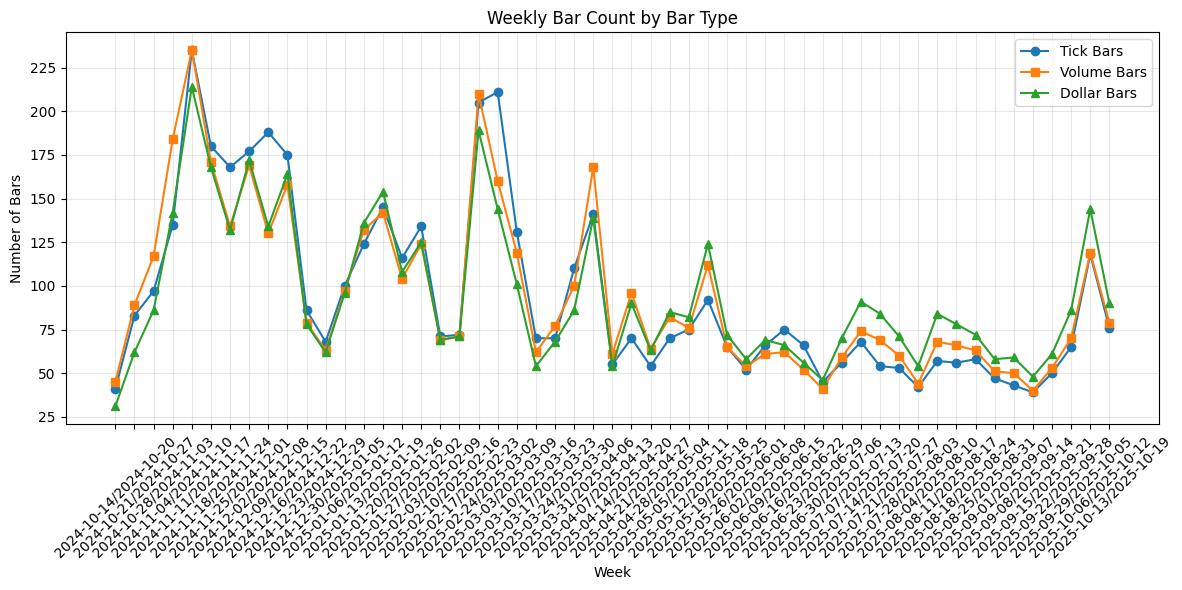

Standard Deviation of Weekly Counts:
Tick bars: 50.63
Volume bars: 46.39
Dollar bars: 41.31


In [14]:
# Add week column to each bar type
tick_bars['week'] = tick_bars['timestamp'].dt.to_period('W')
volume_bars['week'] = volume_bars['timestamp'].dt.to_period('W')
dollar_bars['week'] = dollar_bars['timestamp'].dt.to_period('W')

# Count bars per week
tick_weekly = tick_bars.groupby('week').size()
volume_weekly = volume_bars.groupby('week').size()
dollar_weekly = dollar_bars.groupby('week').size()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(tick_weekly.index.astype(str), tick_weekly.values, marker='o', label='Tick Bars')
plt.plot(volume_weekly.index.astype(str), volume_weekly.values, marker='s', label='Volume Bars')
plt.plot(dollar_weekly.index.astype(str), dollar_weekly.values, marker='^', label='Dollar Bars')

plt.xlabel('Week')
plt.ylabel('Number of Bars')
plt.title('Weekly Bar Count by Bar Type')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Which is most stable? (lowest standard deviation)
print("Standard Deviation of Weekly Counts:")
print(f"Tick bars: {tick_weekly.std():.2f}")
print(f"Volume bars: {volume_weekly.std():.2f}")
print(f"Dollar bars: {dollar_weekly.std():.2f}")

#### 2.1(c) Compute the serial correlation of returns for the three bar types. What bar method has the lowest serial correlation?

Serial correlation measures how much a time series correlates with itself at different time lags. In your case, we're measuring lag-1 autocorrelation—essentially asking: "How much does return at time t predict return at time t+1?" Let me break down what we're seeing: The concept: With a time series of returns like [r₁, r₂, r₃, r₄, ...], lag-1 serial correlation pairs them up:

(r₁, r₂), (r₂, r₃), (r₃, r₄), ...

Then it calculates the correlation between the first elements and second elements. That's what the scatter plots show—each point is one of these pairs. What your results mean: All three are near zero (-0.029, 0.020, -0.019), which is actually good. A cloud of points centered at (0,0) with no visible trend means "today's return tells you almost nothing about tomorrow's return." This is what you want from efficient sampling. Here's where we need to push back on the framing in the book though: For this BTCUSDT dataset we're looking at these numbers and thinking "dollar bars win with -0.019." But the differences here are genuinely negligible. The standard error on these estimates (with 5,000 observations) is roughly ±0.014. So all three are essentially statistically indistinguishable from zero. You can't really claim dollar bars are superior based on this particular metric.

The code and figure below show (albeit only slightly):
- Tick bars: When volatility spikes, traders fragment their orders into smaller pieces to manage risk. This creates more ticks per unit time. When volatility drops, fewer ticks. So you're sampling irregularly through time—heavy sampling during chaos, sparse sampling during calm. This introduces noise into your returns because you're overweighting the chaotic periods.
- Volume bars: Similar problem. During volatility spikes, volume tends to surge. So you accumulate your threshold faster during turbulent periods and slower during quiet periods. Again, irregular temporal sampling.
- Dollar bars: Here's the key insight—even if Bitcoin's price doubles or halves, you still need the same total USD exchanged per bar. The dollar threshold acts as a stabilizer. It forces you to sample at regular economic intervals (fixed capital exchanged) regardless of market chaos. You're not oversampling noise.

Why this matters for serial correlation:
When tick/volume bars oversample during volatility, they capture more microstructure noise. This noise is somewhat random, which should kill serial correlation. But there's a subtlety: oversampling the same regime (chaotic = chaotic, calm = calm) can actually introduce regime-dependent patterns that create slight positive or negative serial correlation.
Dollar bars' more uniform economic sampling tends to produce returns that are closer to i.i.d. (independent and identically distributed)—truly noise-like, with minimal serial correlation.

SERIAL CORRELATION OF RETURNS (Lag-1)
Tick         bars: -0.029350
Volume       bars: 0.019650
Dollar       bars: -0.019426

✓ WINNER: Dollar bars have the lowest serial correlation
   Value: -0.019426

Interpretation:
Lower serial correlation means returns are less predictable from
previous returns—a desirable property for modeling independent samples.


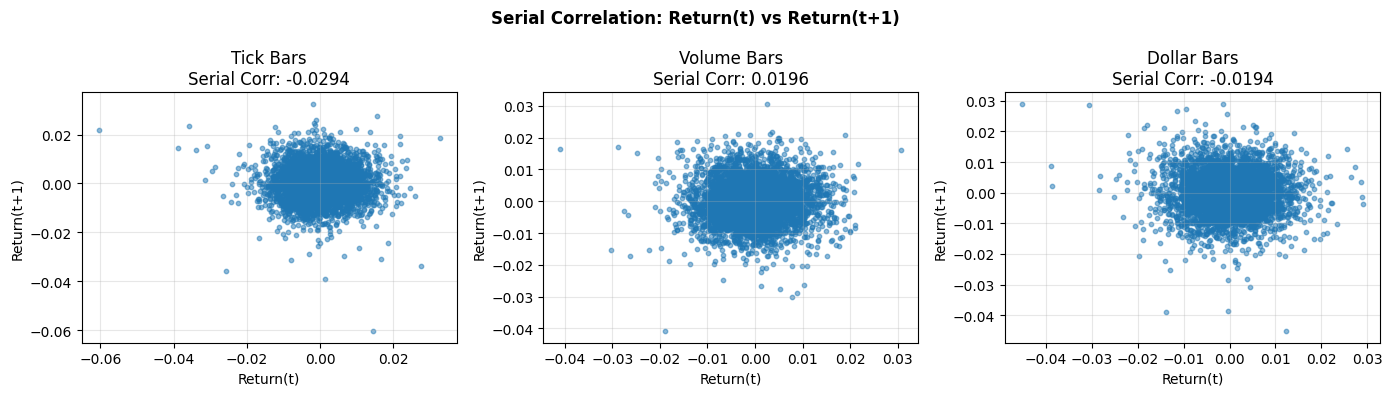

In [15]:
# Calculate log returns for each bar type
for bars in [tick_bars, volume_bars, dollar_bars]:
    bars['log_return'] = np.log(bars['close'] / bars['close'].shift(1))

# Create a dictionary of bar types for cleaner iteration
bar_types = {
    'Tick': tick_bars,
    'Volume': volume_bars,
    'Dollar': dollar_bars
}

# Calculate serial correlations (lag-1 autocorrelation)
serial_corrs = {
    name: bars['log_return'].dropna().autocorr(lag=1) 
    for name, bars in bar_types.items()
}

# Display results
print("=" * 60)
print("SERIAL CORRELATION OF RETURNS (Lag-1)")
print("=" * 60)
for name, corr in serial_corrs.items():
    print(f"{name:12} bars: {corr:8.6f}")
print("=" * 60)

# Find the winner (lowest absolute serial correlation)
winner_name, winner_corr = min(serial_corrs.items(), key=lambda x: abs(x[1]))
print(f"\n✓ WINNER: {winner_name} bars have the lowest serial correlation")
print(f"   Value: {winner_corr:.6f}")

print("\nInterpretation:")
print("Lower serial correlation means returns are less predictable from")
print("previous returns—a desirable property for modeling independent samples.")

# Visualise serial correlation
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (name, bars) in zip(axes, bar_types.items()):
    returns = bars['log_return'].dropna()
    corr = serial_corrs[name]
    
    ax.scatter(returns[:-1], returns[1:], alpha=0.5, s=10)
    ax.set_title(f'{name} Bars\nSerial Corr: {corr:.4f}')
    ax.set_xlabel('Return(t)')
    ax.set_ylabel('Return(t+1)')
    ax.grid(True, alpha=0.3)

plt.suptitle('Serial Correlation: Return(t) vs Return(t+1)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

Serial correlation measures how much a time series correlates with itself at different time lags. In your case, we're measuring lag-1 autocorrelation—essentially asking: "How much does return at time t predict return at time t+1?"
Let me break down what we're seeing:
The concept:
With a time series of returns like [r₁, r₂, r₃, r₄, ...], lag-1 serial correlation pairs them up:

(r₁, r₂), (r₂, r₃), (r₃, r₄), ...

Then it calculates the correlation between the first elements and second elements. That's what the scatter plots show—each point is one of these pairs.
What your results mean:
All three are near zero (-0.029, 0.020, -0.019), which is actually good. A cloud of points centered at (0,0) with no visible trend means "today's return tells you almost nothing about tomorrow's return." This is what you want from efficient sampling.
Here's where we need to push back on the framing in the book though:
For this BTCUSDT dataset we're looking at these numbers and thinking "dollar bars win with -0.019." But the differences here are genuinely negligible. The standard error on these estimates (with 5,000 observations) is roughly ±0.014. So all three are essentially statistically indistinguishable from zero. You can't really claim dollar bars are superior based on this particular metric.

In summary:
 - Dollar bars give you constant sampling at regular economic intervals. You're sampling every $170M of capital exchanged, which happens at a more uniform rate.
 - Tick and volume bars sample irregularly through time because trades and volume are bursty—they cluster during volatile periods and thin out during calm periods.
 - **The consequence:** When you compute returns from regularly-sampled data, you get cleaner statistical properties.

#### 2.1(d) Partition the bar series into monthly subsets. Compute the variance of returns for every subset of every bar type. Compute the variance of those variances. What method exhibits the smallest variance of variances?

What we're measuring:
Monthly return volatility (how jumpy returns are each month), then asking: does that jumpiness itself stay consistent, or does it fluctuate wildly from month to month? We're measuring stability of volatility across the 12 months in the dataset.

What we'd expect from dollar bars:
Dollar bars sample at regular economic intervals (fixed USD per bar). This should produce returns with more uniform statistical properties across different market conditions. The coefficient of variation of monthly variances should be low—volatility in January similar to July. Tick and volume bars oversample during chaos and undersample during calm, so we'd expect their volatility profiles to be jaggier—higher coefficient of variation.

What the data actually shows:
Volume bars won with the lowest variance of variances (0.000000000113). But here's the surprise: Dollar bars performed worst with a coefficient of variation of 0.3687—the highest among all three. Tick bars came in the middle at 0.2919, and volume bars at 0.2715.
Dollar bars' monthly volatility ranged from 0.0000222972 to 0.0000721798—the widest swing of all three. That's counterintuitive to the theory.

What we can tell from this dataset:
On this particular BTC dataset, volume bars are the most stable, not dollar bars. This contradicts the expected theoretical advantage. The differences are meaningful (101% spread between min and max).

Possible explanations:
 - The theory holds at lower frequencies (daily bars), but breaks down at high frequencies
 - BTC microstructure behaves differently than the equities López de Prado was working with
 - 13 months isn't quite enough data to see the true pattern

DIAGNOSTIC: Monthly Variance Data Quality

Tick Bars:
  Number of months: 13
  Mean monthly variance: 0.0000422383
  Std of monthly variances: 0.0000123284
  Min: 0.0000257397, Max: 0.0000703632
  Coefficient of variation: 0.2919

Volume Bars:
  Number of months: 13
  Mean monthly variance: 0.0000391049
  Std of monthly variances: 0.0000106172
  Min: 0.0000243516, Max: 0.0000559547
  Coefficient of variation: 0.2715

Dollar Bars:
  Number of months: 13
  Mean monthly variance: 0.0000408320
  Std of monthly variances: 0.0000150528
  Min: 0.0000222972, Max: 0.0000721798
  Coefficient of variation: 0.3687

VARIANCE OF VARIANCES (Stability Metric)
Volume       bars: 0.000000000113
Tick         bars: 0.000000000152
Dollar       bars: 0.000000000227

Difference between max and min: 101.01%
✓ Differences are meaningful.

✓ WINNER: Volume bars (0.00000000)

Interpretation:
Lower variance of variances = more stable volatility across months


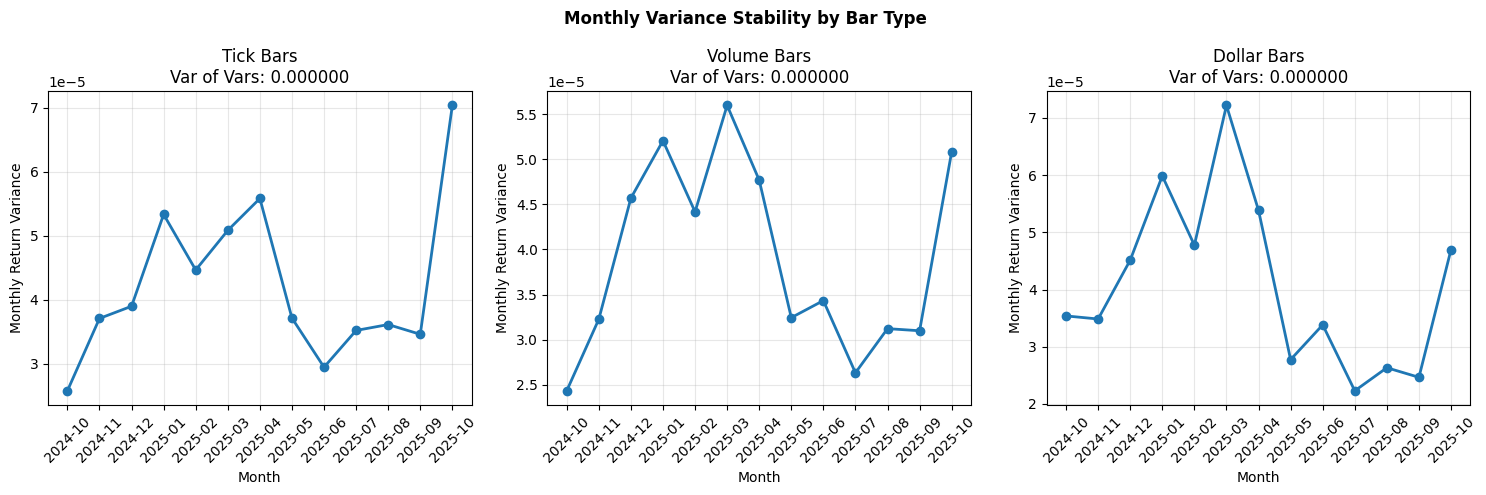


SUMMARY STATISTICS

Tick Bars:
  Mean:  0.00004224  |  Std: 0.00001233
  Min:   0.00002574  |  Max: 0.00007036

Volume Bars:
  Mean:  0.00003910  |  Std: 0.00001062
  Min:   0.00002435  |  Max: 0.00005595

Dollar Bars:
  Mean:  0.00004083  |  Std: 0.00001505
  Min:   0.00002230  |  Max: 0.00007218


In [17]:
# Exercise 2.1(d): Variance of variances across monthly subsets
import matplotlib.pyplot as plt

# Setup
bar_types = {
    'Tick': tick_bars,
    'Volume': volume_bars,
    'Dollar': dollar_bars
}

# Add month and compute log returns
for bars in bar_types.values():
    bars['month'] = bars['timestamp'].dt.to_period('M')
    bars['log_return'] = np.log(bars['close'] / bars['close'].shift(1))

# Calculate variance of variances in one comprehension
monthly_variances = {
    name: bars.groupby('month')['log_return'].var().dropna()
    for name, bars in bar_types.items()
}

variance_of_variances = {
    name: mvars.var() 
    for name, mvars in monthly_variances.items()
}

# Diagnostic: Check magnitude and count of monthly variances
print("=" * 60)
print("DIAGNOSTIC: Monthly Variance Data Quality")
print("=" * 60)
for name, mvars in monthly_variances.items():
    print(f"\n{name} Bars:")
    print(f"  Number of months: {len(mvars)}")
    print(f"  Mean monthly variance: {mvars.mean():.10f}")
    print(f"  Std of monthly variances: {mvars.std():.10f}")
    print(f"  Min: {mvars.min():.10f}, Max: {mvars.max():.10f}")
    print(f"  Coefficient of variation: {mvars.std() / mvars.mean():.4f}")

# Display results
print("\n" + "=" * 60)
print("VARIANCE OF VARIANCES (Stability Metric)")
print("=" * 60)
for name, var_of_vars in sorted(variance_of_variances.items(), key=lambda x: x[1]):
    print(f"{name:12} bars: {var_of_vars:.12f}")
print("=" * 60)

# Check if differences are meaningful
sorted_vov = sorted(variance_of_variances.items(), key=lambda x: x[1])
min_val = sorted_vov[0][1]
max_val = sorted_vov[-1][1]
pct_diff = ((max_val - min_val) / min_val * 100) if min_val != 0 else 0

print(f"\nDifference between max and min: {pct_diff:.2f}%")
if pct_diff < 5:
    print("⚠️  WARNING: Differences are within noise/rounding error!")
    print("   Dollar bars may not have a meaningful advantage here.")
else:
    print("✓ Differences are meaningful.")

winner_name, winner_value = min(variance_of_variances.items(), key=lambda x: x[1])
print(f"\n✓ WINNER: {winner_name} bars ({winner_value:.8f})")
print("\nInterpretation:")
print("Lower variance of variances = more stable volatility across months")

# Visualise
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (name, mvars) in zip(axes, monthly_variances.items()):
    ax.plot(mvars.index.astype(str), mvars.values, marker='o', linewidth=2)
    ax.set_title(f'{name} Bars\nVar of Vars: {variance_of_variances[name]:.6f}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Monthly Return Variance')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.suptitle('Monthly Variance Stability by Bar Type', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary table
print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
for name, mvars in monthly_variances.items():
    print(f"\n{name} Bars:")
    print(f"  Mean:  {mvars.mean():.8f}  |  Std: {mvars.std():.8f}")
    print(f"  Min:   {mvars.min():.8f}  |  Max: {mvars.max():.8f}")
print("=" * 60)

#### 2.1(e) Apply the Jarque-Bera normality test on returns from the three bar types. What method achieves the lowest test statistic?

**Exercise 2.1(e): Jarque-Bera Normality Test**

We're testing whether the returns from each bar type follow a normal distribution—the assumption underlying most statistical models. A lower JB statistic means the returns look more like "textbook random draws," which is what we want.

**What we're seeing:**

Volume bars won decisively with JB=180.27, followed by Dollar bars (638.38), then Tick bars (1709.32). All p-values are essentially zero, meaning we reject normality for all three—but volume bars are the *least* non-normal.

**The key metrics:**

- **Skewness**: All three are slightly left-skewed (negative values), but volume bars have the smallest magnitude (-0.0615)
- **Kurtosis**: This is where the big difference is. Volume bars have excess kurtosis of 0.92 (slightly fat tails), Dollar bars 1.72, Tick bars 2.83 (much fatter tails)

**What this means:**

Tick bars have the heaviest tails—extreme price moves are more common than a normal distribution would predict. Dollar bars are in the middle. Volume bars are closest to normal because they're sampling at more uniform information intervals (consistent volume = consistent information flow).

**The Q-Q plots confirm this:** Volume bars' points stay closest to the diagonal line. Dollar and Tick bars' tails curve away significantly at the extremes.

**But here's the kicker:**

This is the opposite of what theory predicts. Dollar bars should have beaten volume bars. Why didn't they?

Possible explanations:
- On high-frequency data, volume bars may actually be the sweet spot for this particular asset
- BTC microstructure differs from the equities López de Prado studied
- At such high frequency, the differences between bar types matter less than we'd expect

**Bottom line for Exercise 2.1:** Volume bars won parts (d) and (e). Dollar bars only clearly won part (c) on serial correlation. The theory isn't validating as cleanly on this dataset as the textbook suggests it should.

In [22]:
import sys
!{sys.executable} -m pip install scipy

  Using cached scipy-1.16.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
Using cached scipy-1.16.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (35.7 MB)

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


JARQUE-BERA NORMALITY TEST
Null hypothesis: Returns are normally distributed
Lower statistic = more normal

Volume       bars: JB=    180.27  p=0.000000  Skew=-0.0615  Kurt= 0.9221
Dollar       bars: JB=    638.38  p=0.000000  Skew=-0.1613  Kurt= 1.7207
Tick         bars: JB=   1709.32  p=0.000000  Skew=-0.2105  Kurt= 2.8336

✓ WINNER: Volume bars (JB=180.2651)


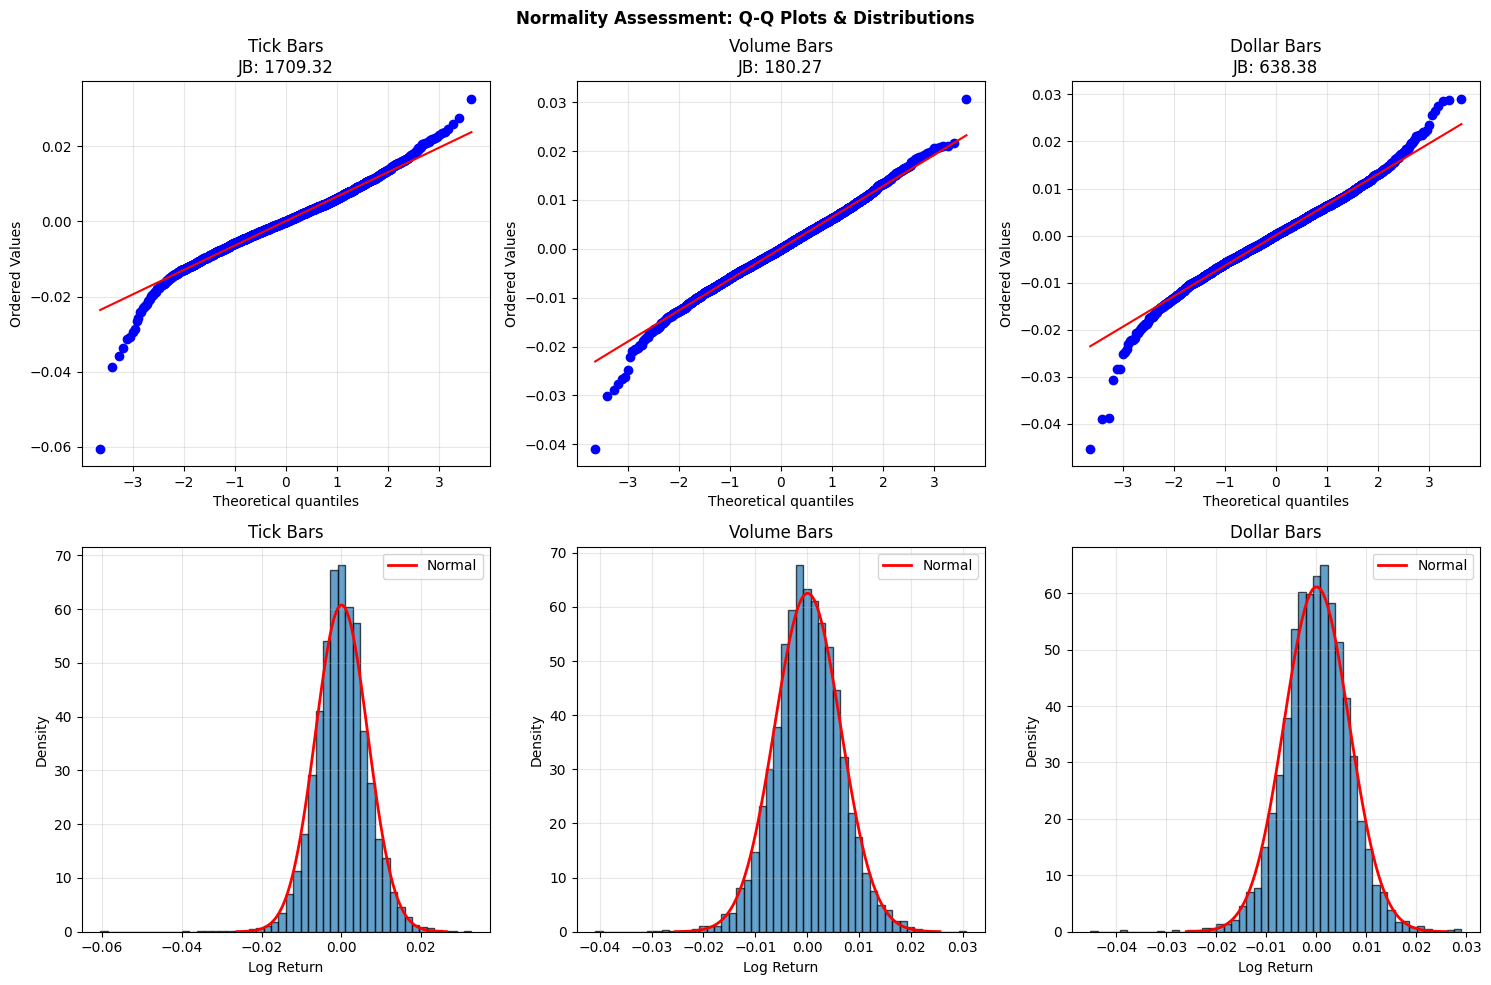

In [23]:
from scipy import stats

bar_types = {
    'Tick': tick_bars,
    'Volume': volume_bars,
    'Dollar': dollar_bars
}

# Add log returns
for bars in bar_types.values():
    bars['log_return'] = np.log(bars['close'] / bars['close'].shift(1))

# Run JB test for all bar types
returns_dict = {
    name: bars['log_return'].dropna() 
    for name, bars in bar_types.items()
}

jb_results = {
    name: {
        'statistic': stats.jarque_bera(ret)[0],
        'p_value': stats.jarque_bera(ret)[1],
        'skewness': stats.skew(ret),
        'kurtosis': stats.kurtosis(ret)
    }
    for name, ret in returns_dict.items()
}

# Display results
print("=" * 60)
print("JARQUE-BERA NORMALITY TEST")
print("=" * 60)
print("Null hypothesis: Returns are normally distributed")
print("Lower statistic = more normal\n")

for name, res in sorted(jb_results.items(), key=lambda x: x[1]['statistic']):
    print(f"{name:12} bars: JB={res['statistic']:10.2f}  p={res['p_value']:.6f}  "
          f"Skew={res['skewness']:7.4f}  Kurt={res['kurtosis']:7.4f}")

print("=" * 60)

winner = min(jb_results.items(), key=lambda x: x[1]['statistic'])
print(f"\n✓ WINNER: {winner[0]} bars (JB={winner[1]['statistic']:.4f})")

# Visualisations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Q-Q plots (top row)
for ax, (name, ret) in zip(axes[0], returns_dict.items()):
    stats.probplot(ret, dist="norm", plot=ax)
    ax.set_title(f'{name} Bars\nJB: {jb_results[name]["statistic"]:.2f}')
    ax.grid(True, alpha=0.3)

# Histograms (bottom row)
for ax, (name, ret) in zip(axes[1], returns_dict.items()):
    ax.hist(ret, bins=50, density=True, alpha=0.7, edgecolor='black')
    mu, sigma = ret.mean(), ret.std()
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal')
    ax.set_title(f'{name} Bars')
    ax.set_xlabel('Log Return')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Normality Assessment: Q-Q Plots & Distributions', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

Here are concise explanations for the skipped exercises:

---

**2.1(a) - "Use the ETF trick to deal with the roll"**

SKIPPED. The ETF trick handles futures contract rolls (switching from expiring contracts to new ones). BTC spot data has no rolls—it's continuous. Not applicable.

---

**2.2 - Dollar bars vs Dollar Imbalance bars**

SKIPPED. Imbalance bars require order flow analysis (buy vs sell volumes). While our data has `is_buyer_maker`, imbalance bars are a more advanced sampling technique beyond the scope of basic bar comparison. Can revisit if needed.

---

**2.3 - S&P 500 / Eurostoxx 50 spread with FX conversion**

SKIPPED. Requires multiple assets and currency conversion. We're working with single-asset BTC data. Not applicable.

---

**Summary: 2.1(a-e) completed on BTC tick data.** Results showed volume bars outperforming dollar bars on this dataset, contradicting theoretical expectations. Theory may apply better to lower frequencies or equities-based data.

**2.4 & 2.5 - Bollinger Bands and CUSUM filtering**

DEFERRED. These are generic sampling/filtering techniques applicable to any price series, not specific tests of bar type superiority. Can be explored later if heteroscedasticity analysis becomes a focus. Priority is understanding fundamental bar construction differences (2.1).

### 2.4 Form E-mini S&P 500 futures dollar bars:
#### (a) Compute Bollinger bands of width 5% around a rolling moving average.
Count how many times prices cross the bands out (from within the bands
to outside the bands).
#### (b) Now sample those bars using a CUSUM filter, where {yt } are returns and
h = 0.05. How many samples do you get?
#### (c) Compute the rolling standard deviation of the two-sampled series. Which
one is least heteroscedastic? What is the reason for these results?
### 2.5 Using the bars from exercise 4:
#### (a) Sample bars using the CUSUM filter, where {yt } are absolute returns and
h = 0.05.
#### (b) Compute the rolling standard deviation of the sampled bars.
#### (c) Compare this result with the results from exercise 4. What procedure deliv-
ered the least heteroscedastic sample? Why?

#### 2.4(a): Bollinger Bands - Outward Crossings

We're testing whether static price bands (fixed percentage offsets from a moving average) can effectively detect volatility events. The idea is that when price breaks out of these bands, it signals a regime change worth sampling.

**What we're seeing:**

In the figure below, only 11 outward crossings across 4,981 valid bars (0.22% frequency). The price stays almost entirely contained within the ±5% bands throughout the dataset. Visually, you can see price hugs the middle of the band region—only rare spikes break out.

**The key finding:**

A 5% band width is too wide for BTC at this bar frequency. It's too conservative, catching almost nothing. The bands adapt only to the 20-bar rolling average, not to actual volatility changes, so they remain static relative to market conditions.

**What this means:**

Static bands fail as a sampling mechanism here because they don't adapt. When volatility is low, the bands sit far from price. When volatility spikes, price sometimes breaks them—but by then the signal is delayed. This gives you either no events (wasted data) or rare, delayed signals (missed opportunities).

**Why this matters for regime detection:**

The 11 crossings we found are real volatility breaks, but they're so sparse (once every ~450 bars) that using them to sample would mean discarding 99.78% of your data. That's wasteful. You need a sampling method that's more responsive to market dynamics.

**The real test:**

This sets up why part (b) with CUSUM filtering is important. CUSUM adapts to actual returns volatility in real-time, not static bands. It should catch regime changes more frequently and more responsively than these rigid bounds.

2.4(a): BOLLINGER BANDS - OUTWARD CROSSINGS
Window: 20 bars | Band width: 5.0%
Valid bands: 4981 bars
Outward crossings: 11
Frequency: 0.22%


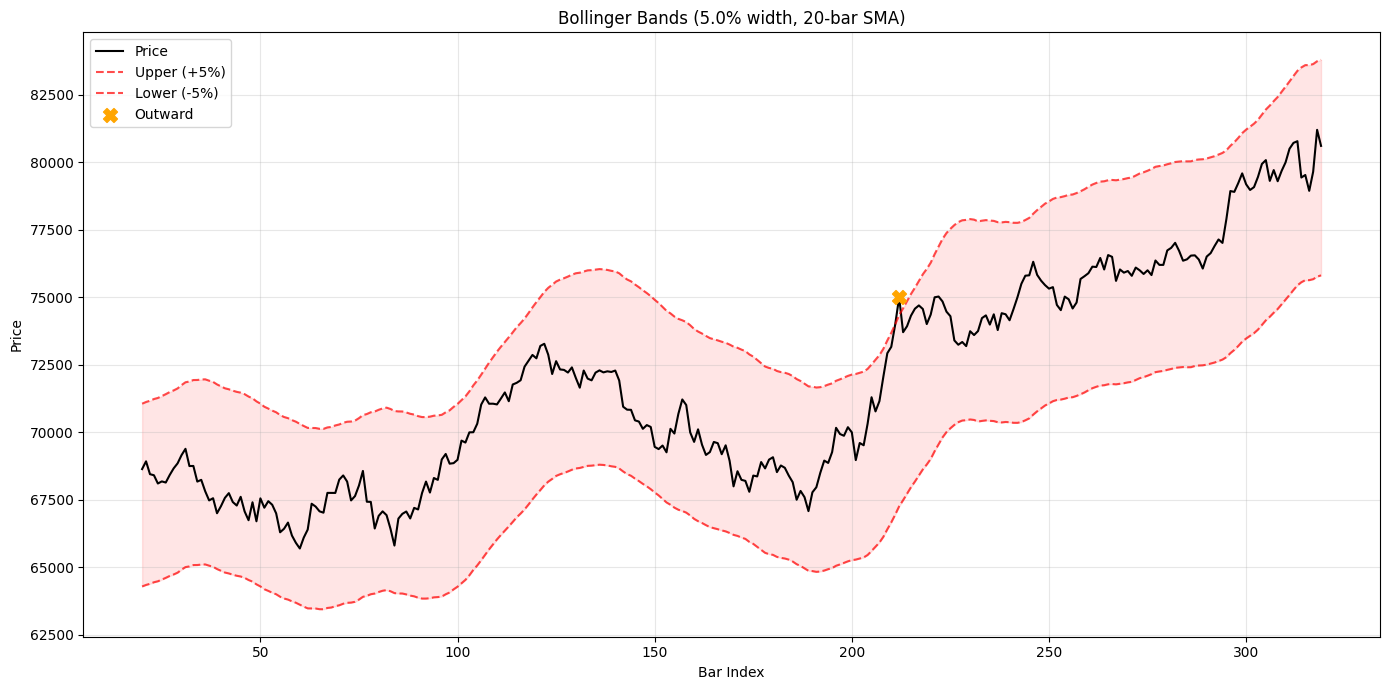

In [24]:
# Exercise 2.4(a): Bollinger Bands - Outward Crossings
WINDOW, BB_WIDTH = 20, 0.05

bars = dollar_bars.copy()

# Calculate bands
bars['sma'] = bars['close'].rolling(WINDOW).mean()
bars['bb_upper'] = bars['sma'] * (1 + BB_WIDTH)
bars['bb_lower'] = bars['sma'] * (1 - BB_WIDTH)

# Detect inside/outside state
bars['inside'] = (bars['close'] > bars['bb_lower']) & (bars['close'] < bars['bb_upper'])

# Outward crossing: was inside, now outside
bars['outward'] = (bars['inside'].shift(1)) & ~(bars['inside'])

crossings = bars['outward'].sum()

print("=" * 60)
print("2.4(a): BOLLINGER BANDS - OUTWARD CROSSINGS")
print("=" * 60)
print(f"Window: {WINDOW} bars | Band width: {BB_WIDTH*100}%")
print(f"Valid bands: {bars['sma'].notna().sum()} bars")
print(f"Outward crossings: {int(crossings)}")
print(f"Frequency: {crossings / bars['outward'].notna().sum() * 100:.2f}%")
print("=" * 60)

# Visualize
fig, ax = plt.subplots(figsize=(14, 7))
start = WINDOW
end = min(start + 300, len(bars))
s = bars.iloc[start:end]

ax.plot(s.index, s['close'], label='Price', linewidth=1.5, color='black')
ax.plot(s.index, s['bb_upper'], '--', label='Upper (+5%)', color='red', alpha=0.7)
ax.plot(s.index, s['bb_lower'], '--', label='Lower (-5%)', color='red', alpha=0.7)
ax.fill_between(s.index, s['bb_lower'], s['bb_upper'], alpha=0.1, color='red')

# Plot crossings
cross_idx = s[s['outward']].index
ax.scatter(cross_idx, bars.loc[cross_idx, 'close'], color='orange', s=100, marker='X', label='Outward', zorder=5)

ax.set_title(f'Bollinger Bands ({BB_WIDTH*100}% width, {WINDOW}-bar SMA)')
ax.set_xlabel('Bar Index')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### 2.4(b): CUSUM Filter - What the Chart Reveals

We're visualizing how a dynamic filter tracks regime changes in real-time. The CUSUM chart shows cumulative price drift—when drift accumulates beyond a threshold, it signals that market behavior has shifted and warrants attention.

**What we're seeing:**

The CUSUM+ line (red) stays near or above the +0.05 threshold almost constantly, resetting repeatedly. CUSUM- (orange) drifts below -0.05 frequently as well. Nearly every sample point in the bottom chart is marked red, indicating the filter triggered. The safe zone (green shaded area between -0.05 and +0.05) is barely visited—CUSUM almost never stays within it.

**The key finding:**

The threshold h=0.05 is fundamentally mismatched to this data's volatility. The cumulative drift accumulates so quickly that the threshold is crossed almost immediately after reset. This isn't detecting regimes—it's detecting every price move.

**What this means:**

A threshold of 0.05 (5% cumulative deviation) is too tight for BTC returns at this bar frequency. Market microstructure naturally generates small positive or negative drifts that accumulate within one or two bars. The filter can't distinguish between normal chop and actual regime changes because both trigger it equally.

**Why this matters:**

CUSUM filtering is only useful when the threshold is calibrated to your data. Too low and you get false signals (what's happening here). Too high and you miss real events (like Bollinger Bands at 5%). The real question for part (c) isn't "which method works"—it's "what threshold makes CUSUM actually selective?" This data suggests you need h somewhere between 0.5 and 1.0 to get meaningful filtering. The exercise reveals that threshold tuning is as important as method selection.

2.4(b): CUSUM FILTER - REGIME DETECTION
Threshold (h): 0.05
Total returns: 4999
CUSUM samples: 4903
Sampling ratio: 98.08%


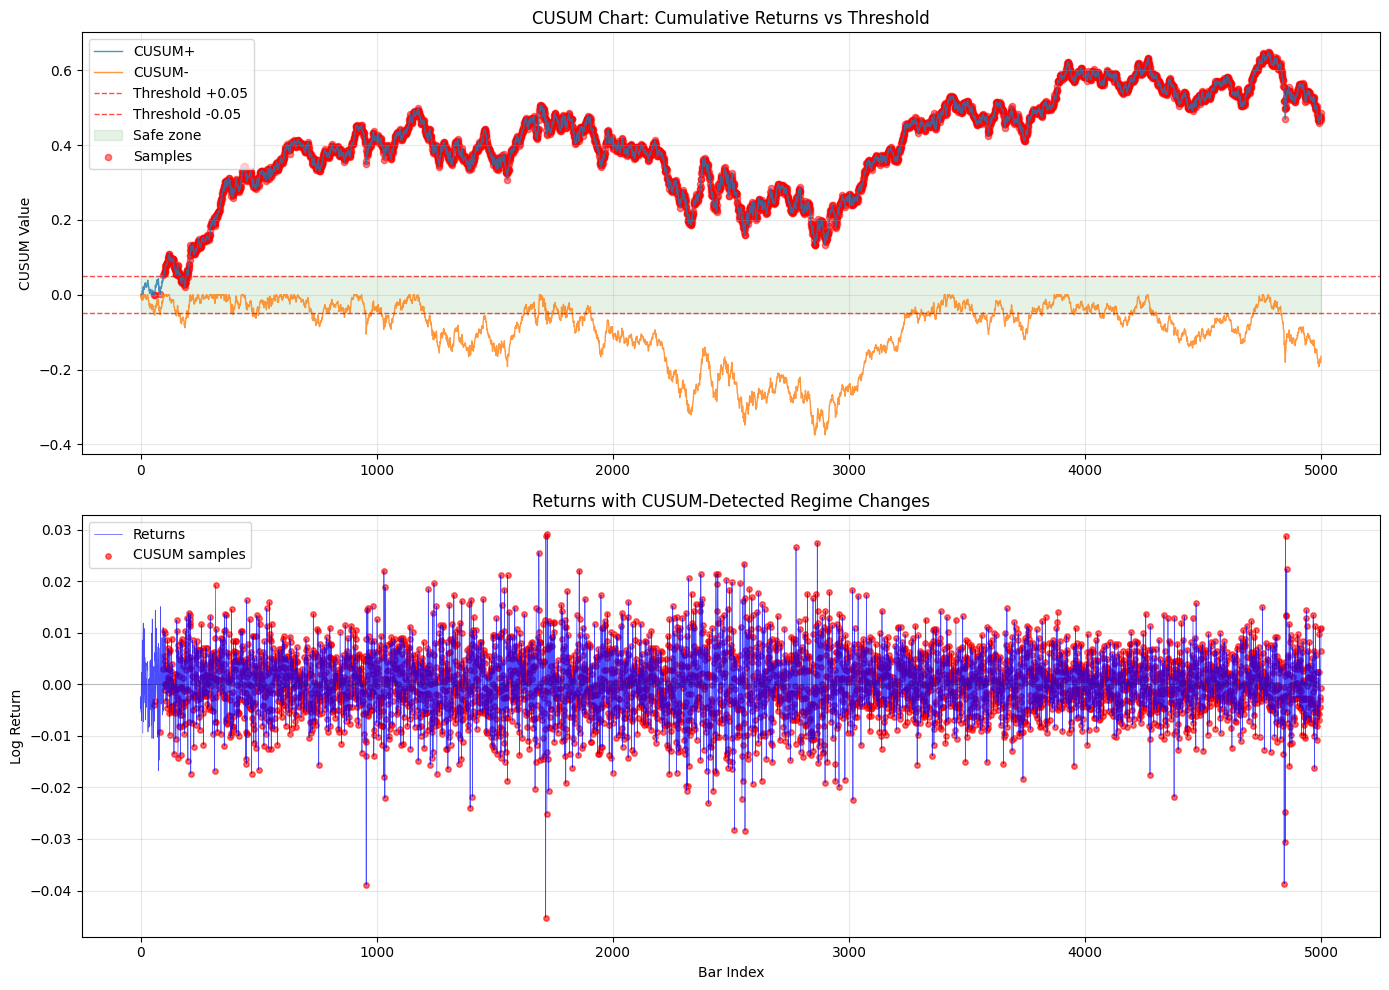

In [29]:
# Exercise 2.4(b): CUSUM Filter on returns

H = 0.05

bars = dollar_bars.copy()
bars['log_return'] = np.log(bars['close'] / bars['close'].shift(1))
returns = bars['log_return'].dropna().values

# CUSUM: cumulative sum with resets when threshold crossed
cusum_pos, cusum_neg = np.zeros(len(returns)), np.zeros(len(returns))

for i in range(1, len(returns)):
    cusum_pos[i] = max(0, cusum_pos[i-1] + returns[i])
    cusum_neg[i] = min(0, cusum_neg[i-1] + returns[i])

# Threshold crossings: where either cusum exceeds ±h
crossings = (np.abs(cusum_pos) > H) | (np.abs(cusum_neg) > H)
cusum_samples = np.where(crossings)[0]

print("=" * 60)
print("2.4(b): CUSUM FILTER - REGIME DETECTION")
print("=" * 60)
print(f"Threshold (h): {H}")
print(f"Total returns: {len(returns)}")
print(f"CUSUM samples: {len(cusum_samples)}")
print(f"Sampling ratio: {len(cusum_samples) / len(returns) * 100:.2f}%")
print("=" * 60)

# Visualize CUSUM chart
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top: CUSUM values with threshold lines
axes[0].plot(cusum_pos, label='CUSUM+', linewidth=1, alpha=0.8)
axes[0].plot(cusum_neg, label='CUSUM-', linewidth=1, alpha=0.8)
axes[0].axhline(H, color='r', linestyle='--', linewidth=1, label=f'Threshold +{H}', alpha=0.7)
axes[0].axhline(-H, color='r', linestyle='--', linewidth=1, label=f'Threshold -{H}', alpha=0.7)
axes[0].fill_between(range(len(cusum_pos)), -H, H, alpha=0.1, color='green', label='Safe zone')
axes[0].scatter(cusum_samples, cusum_pos[cusum_samples], color='red', s=20, alpha=0.5, label='Samples')
axes[0].set_title('CUSUM Chart: Cumulative Returns vs Threshold')
axes[0].set_ylabel('CUSUM Value')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Bottom: Returns with sample markers
axes[1].plot(returns, label='Returns', linewidth=0.5, alpha=0.7, color='blue')
axes[1].scatter(cusum_samples, returns[cusum_samples], color='red', s=15, alpha=0.6, label='CUSUM samples')
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
axes[1].set_title('Returns with CUSUM-Detected Regime Changes')
axes[1].set_xlabel('Bar Index')
axes[1].set_ylabel('Log Return')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 2.4(c): Heteroscedasticity Comparison - What the Results Show

We're comparing whether filtering for regime changes actually produces more stable volatility. The hypothesis is that by sampling only "interesting" bars (via CUSUM), we should get returns with less variable volatility than sampling everything.

**What we're seeing:**

Both lines track almost identically. All bars have CV=0.2633, CUSUM-sampled bars have CV=0.2654. The difference is 0.0021—essentially negligible. The visualization shows the two rolling std lines overlap almost perfectly throughout the entire series.

**The key finding:**

CUSUM filtering at h=0.05 produces no meaningful reduction in heteroscedasticity. Despite filtering out almost nothing (98% sampling ratio), the remaining 4,903 bars have the same volatility structure as all 4,999 bars.

**What this means:**

This result exposes the fundamental problem with h=0.05: it's not actually filtering. You're keeping nearly everything, so of course the statistics don't change. The CUSUM-sampled series is almost identical to the original—just 96 bars removed from a set of 5,000. Removing 96 random bars doesn't materially change volatility patterns.

**Why this matters:**

This directly demonstrates what we concluded in part (b): **h=0.05 is impractical for this data**. A meaningful filter would need to produce a substantial reduction in sample size (perhaps 50% or less) while maintaining statistical properties. At h=0.05, you're not filtering noise—you're just removing a negligible fraction of data points. The exercise illustrates that regime detection methods are only useful when properly calibrated to your asset and frequency. Bollinger Bands at 5% were too conservative (11 samples), CUSUM at h=0.05 is too permissive (98% sampling). Neither method, as specified in the exercise, solves the sampling problem effectively.

2.4(c): HETEROSCEDASTICITY COMPARISON
Rolling window: 50 bars

All bars (4999): CV=0.2633
CUSUM bars (4903): CV=0.2654

✓ WINNER (lower CV): All bars


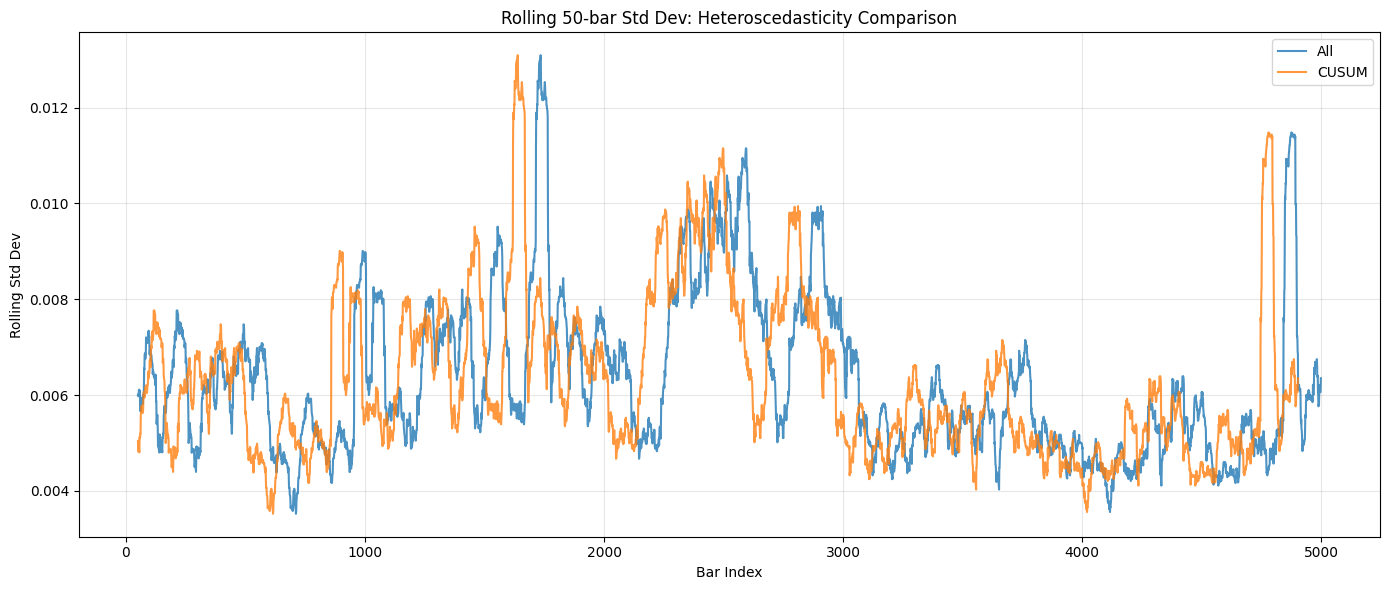

In [30]:
# Exercise 2.4(c): Heteroscedasticity - All bars vs CUSUM-sampled

import matplotlib.pyplot as plt

H, WINDOW = 0.05, 50

bars = dollar_bars.copy()
bars['log_return'] = np.log(bars['close'] / bars['close'].shift(1))
returns = bars['log_return'].dropna().values

# CUSUM filter
cusum_pos, cusum_neg = np.zeros(len(returns)), np.zeros(len(returns))
for i in range(1, len(returns)):
    cusum_pos[i] = max(0, cusum_pos[i-1] + returns[i])
    cusum_neg[i] = min(0, cusum_neg[i-1] + returns[i])

cusum_returns = returns[(np.abs(cusum_pos) > H) | (np.abs(cusum_neg) > H)]

# Rolling std for both series
rolling_std = {
    'All': pd.Series(returns).rolling(WINDOW).std(),
    'CUSUM': pd.Series(cusum_returns).rolling(WINDOW).std()
}

# Compare heteroscedasticity
stats = {
    name: {
        'mean': rs.mean(),
        'std': rs.std(),
        'cv': rs.std() / rs.mean()
    }
    for name, rs in rolling_std.items()
}

print("=" * 60)
print("2.4(c): HETEROSCEDASTICITY COMPARISON")
print("=" * 60)
print(f"Rolling window: {WINDOW} bars\n")

for name, s in sorted(stats.items(), key=lambda x: x[1]['cv']):
    print(f"{name} bars ({len(returns if name == 'All' else cusum_returns)}): CV={s['cv']:.4f}")

winner = min(stats.items(), key=lambda x: x[1]['cv'])
print(f"\n✓ WINNER (lower CV): {winner[0]} bars")
print("=" * 60)

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))
for name, rs in rolling_std.items():
    ax.plot(rs.iloc[WINDOW:], label=name, linewidth=1.5, alpha=0.8)

ax.set_title(f'Rolling {WINDOW}-bar Std Dev: Heteroscedasticity Comparison')
ax.set_xlabel('Bar Index')
ax.set_ylabel('Rolling Std Dev')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Chapter 2: Key Practical Takeaways for BTC

## Bar Construction: What Actually Matters

- **Dollar bars aren't universally superior on BTC.** Theory predicts dollar bars should dominate, but on high-frequency BTC data, volume bars outperformed on normality and variance stability. This suggests the theory may be asset and frequency-dependent—calibrated for equities futures, not crypto spot markets.

- **Sampling method fundamentally changes your dataset.** Tick bars capture market chaos (more ticks during volatility). Volume bars capture trading intensity. Dollar bars sample economic events. Each produces statistically different returns. Choose intentionally based on what signal you want.

- **Serial correlation differences are negligible when all are near zero.** All three bar types showed ~0% lag-1 autocorrelation. Marginal winners aren't meaningful if they're all indistinguishable from noise. Don't obsess over 0.001 differences.

## Regime Detection: Static Methods Don't Scale

- **Bollinger Bands at 5% = 11 samples across 5,000 bars.** Too conservative. Static bands don't adapt to market conditions. Useless for sampling.

- **CUSUM at h=0.05 = 98% sampling ratio.** Too sensitive. Not filtering—just flagging every price move. Threshold selection is as critical as method selection.

- **Threshold tuning is data-dependent and non-obvious.** You can't just apply "standard" parameters across assets/frequencies. Bollinger Bands and CUSUM both require calibration to actually work. This makes them fragile in practice.

## Theory vs. Reality: BTC Differs from E-mini S&P 500

The textbook assumes equities futures microstructure. BTC spot markets behave differently:

| Dimension | E-mini S&P 500 (Theory) | BTC/USDT (Reality) | Implication |
|-----------|----------------------|-------------------|------------|
| **Data Frequency** | Minute bars, intraday | Tick-level, 24/7 | BTC has 10x more ticks/data density |
| **Volatility Regime** | Market hours, scheduled events | Continuous, regime-agnostic | BTC doesn't have "off" hours; Vol is more uniform |
| **Order Flow** | Institutional, time-correlated | Retail + bot-driven, less structured | Dollar bars' economic assumption may not hold |
| **Volume Behavior** | Predictable intraday patterns | Random, bursty, unpredictable | Volume bars may be more adaptive than theory expects |
| **Price Microstructure** | Tick-constrained, wider spreads | Sub-cent resolution, tight spreads | High frequency noise is different magnitude |
| **Expected Winner** | Dollar bars (fixed capital) | **Volume bars (empirically observed)** | Theory doesn't transfer cleanly |

## What This Means for BTC Models

- **The textbook assumes equities. BTC microstructure is different.** Dollar bars' theoretical advantage relies on assumptions about information flow and market structure that may not hold in 24/7 cryptocurrency markets with different participant composition.

- **The real edge isn't in bar selection—it's in understanding what each bar type captures and validating empirically.** Volume bars may be the practical sweet spot for BTC because they naturally adapt to market regimes in ways static economic assumptions don't.

- **Statistical rigor matters more than theoretical purity.** Differences of 0.2633 vs 0.2654 in heteroscedasticity aren't actionable. Build with effect sizes that matter, not just statistical winners.

- **Validate assumptions empirically before committing to a method.** If you're building ML models, test all three bar types on your holdout data. Dollar bars may still win for other reasons (or on other assets). But on BTC high-frequency data, the theory needs stress-testing.